In [1]:
import tensorflow as tf
import numpy as np
import mat73

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

test_file = mat73.loadmat('./Training_set_620000_4D.mat')
x_train, y_train = test_file['XTrain'].T,test_file['YTrain'].T
x_train = np.transpose(x_train,[3,0,1,2])
print(x_train.shape)
print(y_train.shape)

(620000, 64, 32, 1)
(620000, 2)


In [2]:
learning_rate = 0.003
total_epoch = 5
batch_size = 31*20
total_batch = int(len(y_train)/batch_size)

filter_size1 = 8
filter_size2 = 16
filter_size3 = 32

In [3]:
X = tf.placeholder(tf.float32, [None, 64, 32, 1], name='input')
Y = tf.placeholder(tf.float32, [None, 2], name='label')
batch_prob = tf.placeholder(tf.bool, name='batch_prob')

W1 = tf.Variable(tf.random_normal([3, 3, 1, filter_size1], stddev=0.01), name='weight1')
#b1 = tf.Variable(tf.random_normal([filter_size1], name='bias1'))
L1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME') 
L1 = tf.nn.relu(tf.layers.batch_normalization(L1, training=batch_prob, momentum=0.9))
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W2 = tf.Variable(tf.random_normal([3, 3, filter_size1, filter_size2], stddev=0.01), name='weight2')
#b2 = tf.Variable(tf.random_normal([filter_size2], name='bias2'))             
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME') 
L2 = tf.nn.relu(tf.layers.batch_normalization(L2, training=batch_prob, momentum=0.9))
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W3 = tf.Variable(tf.random_normal([3, 3, filter_size2, filter_size3], stddev=0.01), name='weight3')
#b3 = tf.Variable(tf.random_normal([filter_size3], name='bias3'))
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME') 
L3 = tf.nn.relu(tf.layers.batch_normalization(L3, training=batch_prob, momentum=0.9))

W4 = tf.Variable(tf.random_normal([16 * 8 * filter_size3, 2], stddev=0.01), name='weight4')
#b4 = tf.Variable(tf.random_normal([num_class], name='bias4'))
L4 = tf.reshape(L3, [-1, 16 * 8 * filter_size3])
model= tf.matmul(L4, W4) 
model = tf.identity(model, name='model')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(model,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [4]:
for epoch in range(total_epoch):
    total_cost = 0
    shuffle_idx=np.random.permutation(len(y_train))
    x_train_data=x_train[shuffle_idx]
    y_train_data=y_train[shuffle_idx]
    
    for i in range(total_batch):
        batch_x = x_train_data[i*batch_size:(i+1)*batch_size,:,:,:]
        batch_y = y_train_data[i*batch_size:(i+1)*batch_size,:]
        
        cost_val, _ = sess.run([cost, optimizer], 
                               feed_dict = {X: batch_x, Y:batch_y, batch_prob:True})
        total_cost += cost_val
        
    print('Epoch:', '%04d' % (epoch+1), 
         'Avg. loss =', '{:.5f}'.format(total_cost / total_batch))

Epoch: 0001 Avg. loss = 0.09158
Epoch: 0002 Avg. loss = 0.08648
Epoch: 0003 Avg. loss = 0.08595
Epoch: 0004 Avg. loss = 0.08494
Epoch: 0005 Avg. loss = 0.08458


## Test

In [5]:
SNR_table = list(range(-20, 10+1, 2))
fdr_list,mdr_list = [1]*len(SNR_table), [1]*len(SNR_table)
acc_list = []

for SNR_loop in range(len(SNR_table)):
    test_name = './Test_set_108500_snr%d_4D.mat' % SNR_table[SNR_loop]
    test_file = mat73.loadmat(test_name)
    x_test, y_test = test_file['XTest'].T, test_file['YTest'].T
    x_test = np.transpose(x_test,[3,0,1,2])
    test_batch_size = 500
    total_batch = int(len(y_test) / test_batch_size)
    
    busy_cnt, idle_cnt = 0,0
    acc_cnt = 0
    
    for i in range(total_batch):
        batch_x = x_test[i*test_batch_size:(i+1)*test_batch_size,:,:,:]
        batch_y = y_test[i*test_batch_size:(i+1)*test_batch_size,:]
        pred,acc = sess.run([model,accuracy], 
                         feed_dict={X:batch_x, Y:batch_y, batch_prob:False})
        acc_cnt = acc_cnt + acc
        for n in range(len(pred)):
            if (np.argmax(batch_y,1)[n] == 1):
                if (np.argmax(pred,1)[n] == 0):
                    fdr_list[SNR_loop] = fdr_list[SNR_loop] + 1
                busy_cnt = busy_cnt + 1
            else:
                if (np.argmax(pred,1)[n] == 1):
                    mdr_list[SNR_loop] = mdr_list[SNR_loop] + 1
                idle_cnt = idle_cnt + 1
                
    fdr_list[SNR_loop] = fdr_list[SNR_loop] / busy_cnt        
    mdr_list[SNR_loop] = mdr_list[SNR_loop] / idle_cnt
    acc_list.append(acc_cnt/total_batch)    
    
    print('SNR:', '%d' % SNR_table[SNR_loop],' 정확도: %4f' % acc)

SNR: -20  정확도: 0.570000
SNR: -18  정확도: 0.500000
SNR: -16  정확도: 0.556000
SNR: -14  정확도: 0.668000
SNR: -12  정확도: 0.738000
SNR: -10  정확도: 0.896000
SNR: -8  정확도: 0.976000
SNR: -6  정확도: 0.992000
SNR: -4  정확도: 1.000000
SNR: -2  정확도: 1.000000
SNR: 0  정확도: 1.000000
SNR: 2  정확도: 1.000000
SNR: 4  정확도: 1.000000
SNR: 6  정확도: 1.000000
SNR: 8  정확도: 1.000000
SNR: 10  정확도: 1.000000


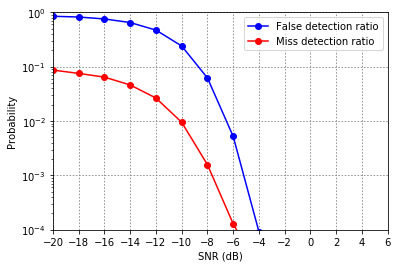

In [8]:
from matplotlib import pyplot as plt

plt.semilogy(SNR_table, fdr_list, '-bo', label='False detection ratio')
plt.semilogy(SNR_table, mdr_list, '-ro', label='Miss detection ratio')
plt.xticks(SNR_table) 
plt.xlim(-20, 6)
plt.ylim(0.0001, 1)
plt.xlabel('SNR (dB)')
plt.ylabel('Probability')
plt.legend()
plt.grid(color='gray',dashes=(2,2))
plt.show()

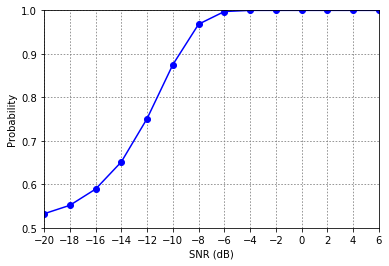

In [9]:
from matplotlib import pyplot as plt

plt.plot(SNR_table, acc_list, '-bo')
plt.xticks(SNR_table) 
plt.xlim(-20, 6)
plt.ylim(0.5, 1)
plt.xlabel('SNR (dB)')
plt.ylabel('Probability')
plt.grid(color='gray',dashes=(2,2))
plt.show()